In [5]:
#libs for setup training set
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Audio
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
from tempfile import TemporaryFile

#libs for Bayes deciding
from math import log

In [2]:
'''
Functions: lpf, upsample, downsample
'''

def upsample(U,x):
    
    #create a length len(x)*[1+(U+1)]-1
    upsampled = np.zeros(len(x)*(1+(U-1))-1)
        
    #interpolate U-1 zeros between every two entries
    for n in range(0,len(upsampled)):
        if (n/U)%1==0: 
            upsampled[n] = x[int(n/U)]
            
        else:
            upsampled[n] = 0

    return upsampled


def lowpass(C):
    wc = np.pi/C/np.pi
    
    #PM filter
    N = 100
    a = [1,0]
    #lpf
    lpf_bands = [0,wc,wc+0.1,1]
    lpf_desired = [1,0] #gain of one for passband, gain of zero for stopband
    lpf = signal.remez(N,lpf_bands,lpf_desired,fs=2)

    w,H_lpf = signal.freqz(lpf,a)

    return lpf


def downsample(D,x):
    
    downsampled = np.zeros(int(len(x)/D))
    
    for n in range(int(len(x)/D)):
        downsampled[n] = x[n*D]
    
    return downsampled



'''
Function: resample
This function will resample any input signal to the input fraction
@param signal: the signal to be resampled
@param numerator: numerator of the fraction
@param denominator: denominator of the fraction
@return signal: resampled signal
'''
def resample(signal, numer, denom):        
    X = np.fft.fft(signal)
    X = np.fft.fftshift(X)  #fft.fft gives a dtft 0-2pi,zero-center it

    #upsampling first
    #upsample by 
    y = upsample(numer,x)
    Y = np.fft.fft(y)
    Y = np.fft.fftshift(Y)

    #post-interpolation filtering
    #create filter
    lpf = lowpass(numer)
    LPF = np.fft.fft(lpf,100000)
    LPF = np.fft.fftshift(LPF)

    #convolution
    y = np.convolve(lpf,y)
    Y = np.fft.fft(y)
    Y = np.fft.fftshift(Y)

    #downsample by 5
    y = downsample(denom,y)
    Y = np.fft.fft(y)
    Y = np.fft.fftshift(Y)

    w1 = np.linspace(-np.pi,np.pi,len(Y))
    plt.figure()
    plt.title('up first')
    plt.plot(w1,abs(Y))
    
    return y

    
'''
Function: resample2Standard
This function will resample any input signal to 44100Hz
@param signal: the signal to be resampled
@param fs: the input signal's sampling rate
@return signal: the resampled signal
'''
def resample2Standard(signal, fs):
    #first determine if the signal is 22100Hz
    if fs == 22100:
        signal = resample(signal, 2, 1)
    else:
        signal = resample(signal, 44100, fs)
    return signal


'''
exp main
'''
exp_sig = np.array([np.sin(np.pi*i) for i in range(0,22500)])
res_sig = resample2Standard(exp_sig, 22500)
plt.figure()
plt.title("exp")
plt.plot(exp_sig)
plt.figure()
plt.title("res")
plt.plot(res_sig)

NameError: name 'x' is not defined

In [9]:
'''
Function: normalize the input list
@param arr: input list
@return arr: output list
'''
def normalize(arr):
    #get the summation of all elements
    sum = 0
    for i in range(len(arr)):
        sum = sum + arr[i]
        
    #iteratively normalize
    #make whole arr sum to 100
    for i in range(len(arr)):
        arr[i] = arr[i]/sum * 100   
    return arr


'''
Function: get steady state a time-domain signal
@param sig: input time-domain signal
@return sts_sig: the stead-state part of the input
'''
def getSteadyState(sig):
    #first get the amplitude of the signal
    all_sig = sig * sig
    #first get the average amplitude
    avg = sum(all_sig)/len(all_sig)
    #find the part below avgerage from the back
    rev_sig = all_sig[::-1]
    for i in range(0,len(rev_sig)):
        if rev_sig[i] > avg:
            back_idx = i
            break
    back_idx = len(rev_sig) - back_idx
    #find the part below avgerage from the front
    for i in range(0,len(all_sig)):
        if all_sig[i] > avg:
            front_idx = i
            break
   
    #get the steady-state signal
    sts_sig = sig[front_idx : back_idx]
#     print("sts's length: ", sts_sig.shape, "original's length ",sig.shape)
    
    return sts_sig

workspace: /mnt/c/Users/24488/Desktop/Study/In_reg/ece397_project
loading in: instru_types.txt
types include ['flute', 'clarinet', 'piano']
loading completed
loading in: clarinet01.wav
loading in: flute01.wav
loading in: flute02.wav
loading in: piano01.wav
start FFT
FFT completed


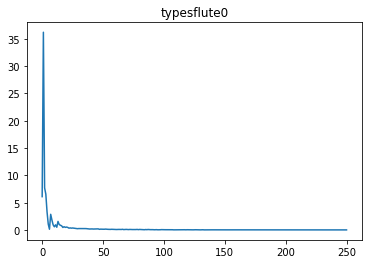

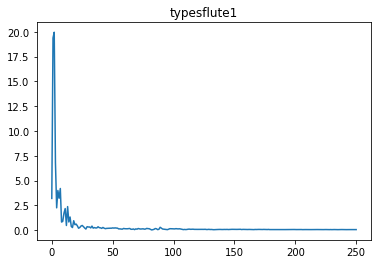

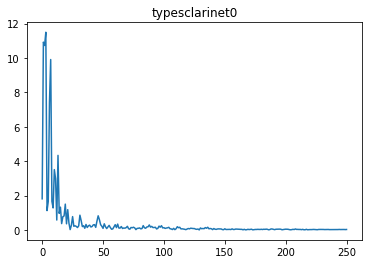

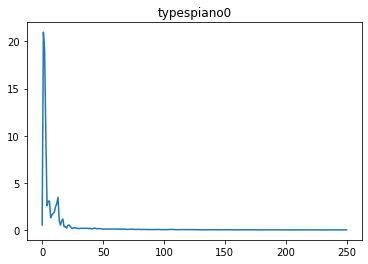

In [4]:
#get the current workspace's abs path
path = os.getcwd()
print("workspace: " + path)
#get the file names of instrument sounds
snds_path = os.listdir(path + '/instru_snds')


#get the types of instruments
for file in snds_path:
    if file.endswith(".txt"):
        print("loading in: " + file)
        types = []
        f = open('instru_snds/' + file, "r")
        for x in f:
            if x.endswith('\n'):
                types.append(x.rstrip('\n'))
            else:
                types.append(x)
f.close()
print("types include", types)
print("loading completed")


#get all time-domain signals
#initialize the 2-D array
all_snds = [[] for i in range(len(types))]
all_fs = []
for file in snds_path:
    if file.endswith(".wav"):
        #find which type it is
        for i in range (len(types)):
            if file.startswith(types[i]):
                print("loading in: " + file)
                audio = np.array([])
                fs,audio = wavfile.read('instru_snds/' + file) #load the data
                snds = all_snds[i]
                snds.append(audio)
                all_fs.append(fs)


#get the steady-states of snds
for i in range(0,len(all_snds)):
    for j in range(0, len(all_snds[i])):
        all_snds[i][j] = getSteadyState(all_snds[i][j])
        all_snds[i][j] = np.asarray(all_snds[i][j])
all_fs = np.asarray(all_fs)


#FFT
print("start FFT")
#initialize the 2-D array
all_FFTs = [[[]for i in range(len(all_snds[j]))] for j in range(len(types))]

for i in range(len(types)):
    for j in range(len(all_snds[i])):
        audio = all_snds[i][j]
        AUD = np.fft.rfft(audio,500)
        AUD = np.absolute(AUD)
        AUD = normalize(AUD)
        all_FFTs[i][j] = AUD
        
        plt.figure()
        plt.plot(all_FFTs[i][j])
        plt.title("types" + types[i] + str(j))
                  
print("FFT completed")


#flatten the array for next step(preferably not)
labels = []
all_FFTs_flat = []
for i in range(len(types)):
    for j in range(len(all_FFTs[i])):
        all_FFTs_flat.append(all_FFTs[i][j])
        labels.append(types[i])

labels = np.asarray(labels)
all_FFTs_flat = np.asarray(all_FFTs_flat)
        
#output the array
test_arr = ([1,2,3,4,5])
np.save("labels.npy", labels)
np.save("train_set", all_FFTs_flat)

In [7]:
#set up input
'''
Function: setup the input signal to return its FFT arrays
@param input: input audio array
@param fs: the sampling rate of the input signal
@return input_FFTs: output array of FFTs
'''
def setupInput(input,fs):
    #first get the absolute time duration of the input
    input = getSteadyState(input)
    input_FFTs = []

    #cut the signal into pieces of 2 seconds
    i = 0
    if len(input)/fs < 2:
        in_piece = input
        AUD = np.fft.rfft(input,500)
        AUD = np.absolute(AUD)
        AUD = normalize(AUD)
        input_FFTs.append(AUD)
        
    else:
        i = 0
        while (i+2)*fs < len(input):
            in_piece = input[i*fs:(i+2)*fs]
            AUD = np.fft.rfft(input,500)
            AUD = np.absolute(AUD)
            AUD = normalize(AUD)
            input_FFTs.append(AUD)
            i = i+2
    return input_FFTs

In [113]:
import numpy as np

def harmonic_in_instrument(harmonic, instrument_spec):
    threshold = 40        # this constant requires further modification
#     print(type(harmonic))
#     print(len(harmonic))
    for spec in instrument_spec:
#         print(type(np.asarray(spec)))
#         print(len(spec))
#         print(instrument_spec.index(spec))
        if np.linalg.norm(np.asarray(spec) - harmonic) < threshold:
            return instrument_spec.index(spec)
    return 0

In [118]:
# naive_bayes.py
# ---------------
# Licensing Information:  You are free to use or extend this projects for
# educational purposes provided that (1) you do not distribute or publish
# solutions, (2) you retain this notice, and (3) you provide clear
# attribution to the University of Illinois at Urbana-Champaign
#
# Created by Justin Lizama (jlizama2@illinois.edu) on 09/28/2018

"""
This is the main entry point for MP4. You should only modify code
within this file -- the unrevised staff files will be used for all other
files and classes when code is run, so be careful to not modify anything else.
"""
# import nltk
import numpy as np
from math import log

def naiveBayes(train_set, train_labels, dev_set):
    """
    train_set - List of list of words corresponding with each movie review
    example: suppose I had two reviews 'like this movie' and 'i fall asleep' in my training set
    Then train_set := [['like','this','movie'], ['i','fall','asleep']]

    train_labels - List of labels (instruments) corresponding with train_set
    example: Suppose I had two reviews, first one was positive and second one was negative.
    Then train_labels := [1, 0]

    dev_set - List of list of words corresponding with each review that we are testing on
              It follows the same format as train_set

    smoothing_parameter - The smoothing parameter you provided with --laplace (1.0 by default)
    """
    # TODO: Write your code here
    # return predicted labels of development set
    smoothing_parameter = 0.005
    instrument1_spec = list()   # flute
    instrument1_occur = list()
    instrument2_spec = list()   # clarinet
    instrument2_occur = list()
    instrument3_spec = list()   # piano
    instrument3_occur = list()


    
#     instrument4 = dict()
#     instrument5 = dict()

    for i in range(len(train_set)):
        if train_labels[i] == "flute":       # the first instrument name. 某一个音有哪些harmonic 和 harmonic number
                                        # dict{(array of amplitudes):string (tone of an instrument)}
#             for harmonics in train_set[i]:
#             print(train_set[i])
#             print(instrument1_spec)
            if train_set[i].tolist() in instrument1_spec:             #if harmonics in instrument1:
                instrument1_occur[instrument1_spec.index(train_set[i].tolist())] += 1          #train_set[i] <---> harmonics
            else:
                instrument1_spec.append(train_set[i].tolist())
                instrument1_occur.append(1)
                    
        elif train_labels[i] == "clarinet":
#             for harmonics in train_set[i]:
            if train_set[i].tolist() in instrument2_spec:
                instrument2_occur[instrument2_spec.index(train_set[i].tolist())] += 1
            else:
                instrument2_spec.append([train_set[i].tolist()])
                instrument2_occur.append(1)

        else: 
            if train_set[i].tolist() in instrument3_spec:
                instrument3_occur[instrument3_spec.index(train_set[i].tolist())] += 1
            else:
                instrument3_spec.append(train_set[i].tolist())
                instrument3_occur.append(1)


    instrument1_occur[-1] = 0
    instrument2_occur[-1] = 0
    instrument3_occur[-1] = 0

    for occurence in range(0, len(instrument1_occur)):
        instrument1_occur[occurence] += smoothing_parameter

    for occurence in range(0, len(instrument2_occur)):
        instrument2_occur[occurence] += smoothing_parameter

    for occurence in range(0, len(instrument3_occur)):
        instrument3_occur[occurence] += smoothing_parameter
        
    Sum1 = sum(instrument1_occur)
    Sum2 = sum(instrument2_occur)
    Sum3 = sum(instrument3_occur)

#     probability_1 = dict()
#     probability_2 = dict()
#     probability_3 = dict()

    for harmonics in range(0, len(instrument1_occur)):
        instrument1_occur[harmonics] = instrument1_occur[harmonics]/Sum1
    for harmonics in range(0, len(instrument2_occur)):
        instrument2_occur[harmonics] = instrument2_occur[harmonics]/Sum2
    for harmonics in range(0, len(instrument3_occur)):
        instrument3_occur[harmonics] = instrument3_occur[harmonics]/Sum3
   
    ret = list()
#     print(dev_set)
    
    for i in range(len(dev_set)):
        log_instrument1 = log(1./3.)
        log_instrument2 = log(1./3.)
        log_instrument3 = log(1./3.)

        for harmonic in dev_set:
            if harmonic_in_instrument(harmonic, instrument1_spec):
#                 print(harmonic.tolist())
                log_instrument1 += log(instrument1_occur[instrument1_spec.index(harmonic.tolist())])
            else:
                log_instrument1 += log(instrument1_occur[-1])

            if harmonic_in_instrument(harmonic.tolist(), instrument2_spec):
                log_instrument2 += log(instrument2_occur[instrument2_spec.index(harmonic.tolist())])
            else:
                log_instrument2 += log(instrument2_occur[-1])
                
            if harmonic_in_instrument(harmonic.tolist(), instrument3_spec):
                log_instrument3 += log(instrument3_occur[instrument3_spec.index(harmonic.tolist())])
            else:
                log_instrument3 += log(instrument3_occur[-1])

        log_max = max(log_instrument1, log_instrument2, log_instrument3)
        if log_max == log_instrument1:
            ret.append(1)

        elif log_max == log_instrument2:
            ret.append(2)

        elif log_max == log_instrument3:
            ret.append(3)
                                                
#         if log_instrument1 > log_instrument2:
#             if log_instrument3 > log_instrument1:
#                 ret.append(2)
#             else:
                
#         else:
#             ret.append(0)
    return ret

In [119]:
# mp3.py
# ---------------
# Licensing Information:  You are free to use or extend this projects for
# educational purposes provided that (1) you do not distribute or publish
# solutions, (2) you retain this notice, and (3) you provide clear
# attribution to the University of Illinois at Urbana-Champaign
#
# Created by Justin Lizama (jlizama2@illinois.edu) on 09/28/2018
import sys
import argparse
import configparser
import copy
import numpy as np

# import reader
# import naive_bayes as nb

"""
This file contains the main application that is run for this MP.
"""

def compute_accuracies(predicted_labels, dev_set, dev_labels):
    yhats = predicted_labels
    accuracy = np.mean(yhats == dev_labels)
    tp = np.sum([yhats[i] == dev_labels[i] and yhats[i] == 1 for i in range(len(yhats))])
    precision = tp / np.sum([yhats[i] == 1 for i in range(len(yhats))])
    recall = tp / (np.sum([yhats[i] != dev_labels[i] and yhats[i] == 0 for i in range(len(yhats))]) + tp)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, f1, precision, recall


def main():
    print("inside")
    train_set = np.load("train_set.npy")
    train_labels = np.load("labels.npy")
    print("test data read")
#     dev_set, dev_labels = reader.load_dataset(args.training_dir,args.development_dir,args.stemming,args.lower_case)
    fs,test_sig = wavfile.read("rcl302.2.wav") #load the data
    print("test data read")
    test_FFT = setupInput(test_sig,fs)

    predicted_labels = naiveBayes(train_set, train_labels, test_FFT)
    print(predicted_labels)
    print("testing")
        

main()
    


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser(description='CS440 MP4 Naive Bayes')

#     parser.add_argument('--training', dest='training_dir', type=str, default = '../data/movies_review/train',
#                         help='the directory of the training data')
#     parser.add_argument('--development', dest='development_dir', type=str, default = '../data/movies_review/dev',
#                         help='the directory of the development data')
#     parser.add_argument('--stemming',dest="stemming", type=bool, default=False,
#                         help='Use porter stemmer')
#     parser.add_argument('--lower_case',dest="lower_case", type=bool, default=False,
#                         help='Convert all word to lower case')
#     parser.add_argument('--laplace',dest="laplace", type=float, default = 1.0,
#                         help='Laplace smoothing parameter - default 1.0')
#     parser.add_argument('--pos_prior',dest="pos_prior", type=float, default = 0.8,
#                         help='Positive prior, i.e. Num_positive_comments / Num_comments')
#     args = parser.parse_args()
#     main(args)


inside
test data read
test data read
[2]
testing
